In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Preparing The Data

In [2]:
import pathlib
data_dir = r"flowers"
data_dir = pathlib.Path(data_dir) 

In [3]:
print(data_dir)

flowers


flowers\california_poppy\10069934253_582a436521_c.jpg


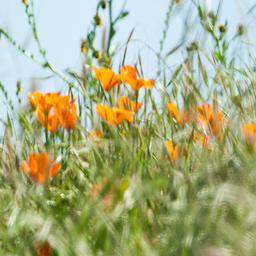

In [4]:
roses = list(data_dir.glob('california_poppy/*'))
print(roses[0])
PIL.Image.open(str(roses[0])) #roses sınıfının ilk görseline bakalım

In [5]:
img_height,img_width=180,180   #görüntü boyutu tanımlandırıyoruz
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(   #veri seti yükleme
  data_dir,
  validation_split=0.2,  #veri setinin %20 si validation için kullanılacak
  subset="training",
  seed=123,   #veri setinin rastgele bir şekilde karıştırılması için kulllanılan seed belirtir.
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15740 files belonging to 16 classes.
Using 12592 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size) 

Found 15740 files belonging to 16 classes.
Using 3148 files for validation.


In [7]:
class_names = train_ds.class_names  #sınıflarımıza bakalım
print(class_names)

['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion', 'iris', 'magnolia', 'rose', 'sunflower', 'tulip', 'water_lily']


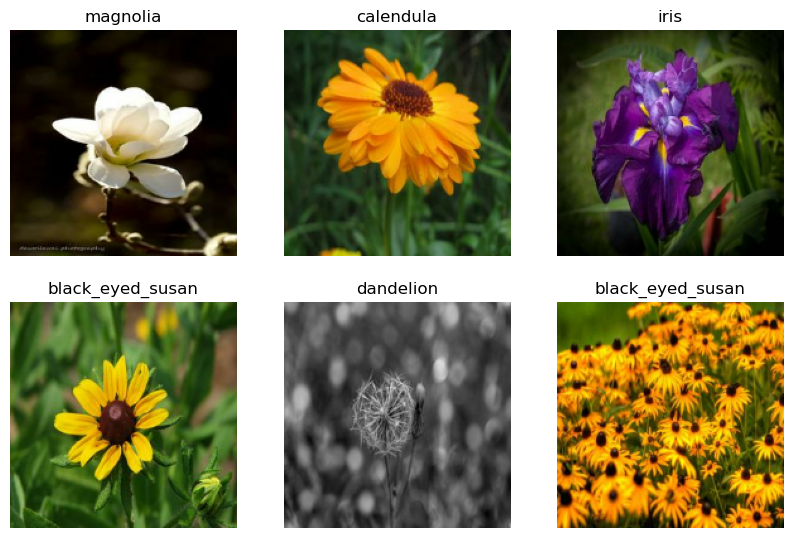

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))  #görselleştirme alanı
for images, labels in train_ds.take(1):  #Veri Setinden 1 (take(1) Parti (Batch) Alma ve Görselleri Görselleştirme:
  for i in range(6):  # ilk 6 görüntü
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])  #başlığı sınıf adı oalrak aayrlıyoruz
    plt.axis("off")

### One-hot kodlama, sınıf etiketlerini binary (ikili) vektörlere dönüştüren bir işlemdir.

In [9]:
def one_hot_encode(image, label): # görüntü ve onun etiketini alır ve etiketi one-hot (tek-seçimli) kodlamaya dönüştürür. 
    label = tf.one_hot(label, num_classes)
    return image, label

In [10]:
num_classes = len(class_names)  #sınıf sayısı


In [11]:
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)

# Training The Model


In [12]:
resnet_model = Sequential()  #yeni bir model oluşturma

#önceden eğitilmiş ResNet50 modelini içe aktarma
pretrained_model= tf.keras.applications.ResNet50(include_top=False,   #sınıflandırma katmanını dahil etmiyoruz çünkü kendi özel sınıflandırma katmanımızı ekleyeceğiz
                   input_shape=(180,180,3),  #3 kanallı (RGB)
                   pooling='avg',classes=5,
                   weights='imagenet')  #Modelin ImageNet veri seti üzerinde önceden eğitilmiş ağırlıklarını kullanmasını belirtir.

#Bu döngü, önceden eğitilmiş modeldeki tüm katmanların eğitim sırasında güncellenmemesi için trainable özelliğini False olarak ayarlar. 
#Bu, transfer öğrenmenin bir parçasıdır ve daha önce öğrenilmiş özelliklerin korunmasını sağlar.
for layer in pretrained_model.layers:
        layer.trainable=False
    
resnet_model.add(pretrained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dropout(0.5))  # Dropout katmanı
resnet_model.add(layers.Dense(16, activation='softmax'))

In [13]:
resnet_model.summary()  #katmanların özeti

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                8208      
Total params: 24,645,008
Trainable params: 1,057,296
Non-trainable params: 23,587,712
_________________________________________________________________


In [14]:
#yapılandırma
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy']) 

In [15]:
##model derleme
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/50
394/394 [==============================] - 676s 2s/step - loss: 0.9085 - accuracy: 0.7185 - val_loss: 0.4846 - val_accuracy: 0.8450
Epoch 2/50
394/394 [==============================] - 669s 2s/step - loss: 0.5148 - accuracy: 0.8335 - val_loss: 0.3806 - val_accuracy: 0.8723
Epoch 3/50
394/394 [==============================] - 669s 2s/step - loss: 0.4301 - accuracy: 0.8568 - val_loss: 0.3743 - val_accuracy: 0.8875
Epoch 4/50
394/394 [==============================] - 665s 2s/step - loss: 0.3580 - accuracy: 0.8802 - val_loss: 0.3489 - val_accuracy: 0.8875
Epoch 5/50
394/394 [==============================] - 671s 2s/step - loss: 0.3178 - accuracy: 0.8917 - val_loss: 0.3494 - val_accuracy: 0.8926
Epoch 6/50
394/394 [==============================] - 708s 2s/step - loss: 0.2948 - accuracy: 0.9001 - val_loss: 0.3512 - val_accuracy: 0.8993
Epoch 7/50
394/394 [==============================] - 669s 2s/step - loss: 0.2609 - accuracy: 0.9120 - val_loss: 0.3362 - val_accuracy: 0.8980

# Evaluating The Model
### eğitim sırasında kaydedilen eğitim ve doğrulama (validation) doğruluk değerlerini kullanarak bir grafik oluşturur. Amaç, modelin eğitim sürecindeki doğruluğunun ve doğrulama setindeki doğruluğunun nasıl değiştiğini görselleştirmektir.

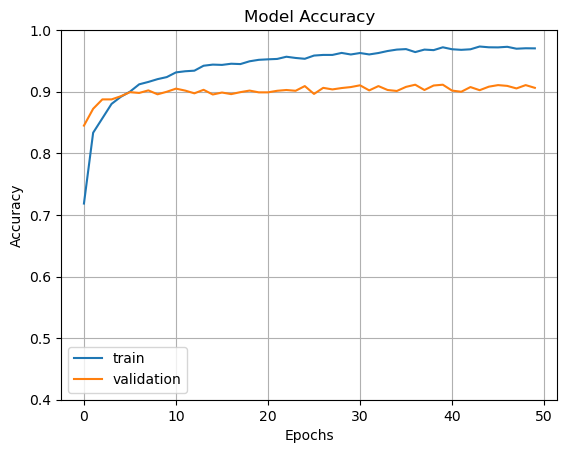

In [16]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

###  Bu kod, eğitim sırasında elde edilen eğitim kaybı (loss) ve doğrulama (validation) kaybı değerlerini kullanarak bir grafik oluşturur. Amacı, modelin eğitim sürecindeki kayıp (hata) değerlerinin nasıl değiştiğini görselleştirmektir.

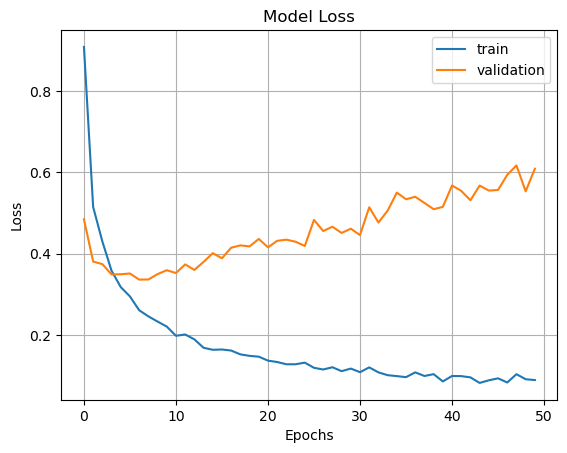

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions

In [32]:
import cv2
test_image = data_dir / "iris"
first_image_path = sorted(test_image.glob("*"))[0]  # Iris klasöründeki ilk görüntü dosyasının yolunu alır

# Görüntüyü okuma ve işleme
image = cv2.imread(str(first_image_path))
image_resized = cv2.resize(image, (img_height, img_width))
image = np.expand_dims(image_resized, axis=0)
print(image.shape)


(1, 180, 180, 3)


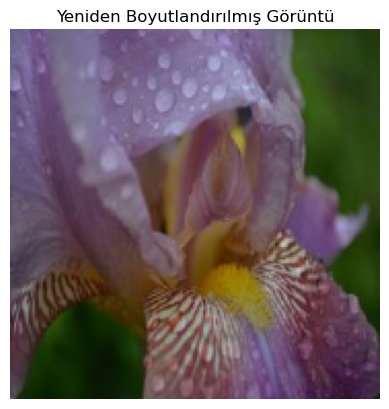

In [33]:
# Resmi matplotlib ile göster
plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
plt.title("Yeniden Boyutlandırılmış Görüntü")
plt.axis("off")
plt.show()

In [34]:
pred=resnet_model.predict(image)  #görüntünün sınıflandırılma tahmini
print(pred)   #her bir sınıf için olasılık değerlerini içeren bir dizi

[[3.4730477e-24 5.3743961e-19 2.1160736e-28 9.1375507e-27 1.3725663e-20
  3.5088905e-20 3.3671085e-22 2.3925043e-31 1.7071710e-19 1.7597573e-34
  1.0000000e+00 4.8193946e-20 2.2164637e-24 5.3523246e-25 7.7408116e-27
  9.0098480e-23]]


In [35]:
output_class=class_names[np.argmax(pred)]  #en yüksek olasılığa sahip olan sınıfın dizinini bulur
print("The predicted class is", output_class)

The predicted class is iris
